In [23]:
from qiskit import *
import numpy as np


%matplotlib inline
from qiskit.tools.visualization import plot_histogram

from matplotlib import style
style.use("dark_background")

In [24]:
secretnumber = '1001'
n = len(secretnumber)

In [25]:
#circuit = QuantumCircuit(6+1, 6) # Six which is the number of qubits plus one qubit and 6 classical bits in which we will store the results.
circuit = QuantumCircuit(n+1, n)

#circuit.h([0,1,2,3])
circuit.h(range(n)) # This way we can apply the H gate to all secret numbers
#circuit.x(6)
circuit.x(n) # apply this gate to our last qubit
#circuit.h(6)
circuit.h(n) # apply this gate to our last qubit


circuit.barrier()

#for every 1 in the sercet number we are applying a CX gate

#circuit.cx(3, 4) # put a cx gate from the 5th to the 6th qubit
#circuit.cx(0, 4) # put a cx gate from the 0th to the 6th qubit 

for ii, yesno in enumerate(reversed(secretnumber)): # reverses the secretnumber
        if yesno == '1':
            circuit.cx(ii, n)

circuit.barrier()

#circuit.h([0,1,2,3])
circuit.h(range(n))

circuit.barrier()

#lets measure

#circuit.measure([0,1,2,3], [0,1,2,3]) 
circuit.measure(range(n), range(n))

In [26]:
#nqubits = 3
#circuit  = QuantumCircuit(nqubits, nqubits)
#circuit.h(0)
#circuit.cx(0,1)
#circuit.cx(1,2)
#circuit.measure([0,1,2], [0,1,2])

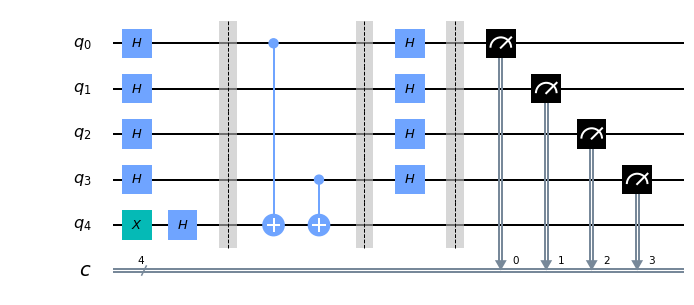

In [27]:
circuit.draw(output = 'mpl')

In [28]:
simulator = Aer.get_backend('qasm_simulator')
result = execute(circuit, backend=simulator, shots=1).result()
counts = result.get_counts()

In [29]:
print(counts)

{'1001': 1}


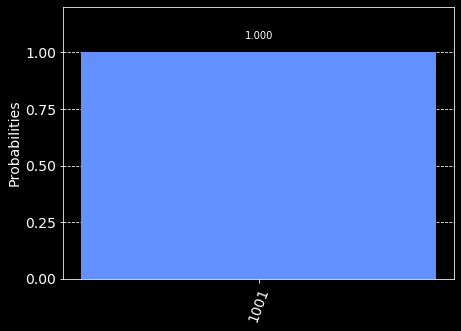

In [30]:
from qiskit.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

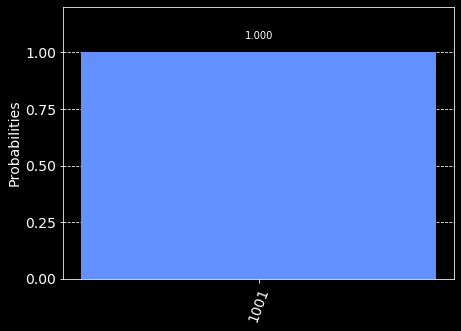

In [31]:
result = execute(circuit, backend=simulator, shots=1024).result()
plot_histogram(result.get_counts(circuit))

In [32]:
#simulator = Aer.get_backend('qasm_simulator')
#sim_result = execute(circuit, backend = simulator, shots=1024).result()

In [33]:
#from qiskit.visualization import plot_histogram

In [34]:
#plot_histogram(sim_result.get_counts(circuit))

In [35]:
IBMQ.load_account()
provider = IBMQ.get_provider('ibm-q')
device = provider.get_backend('ibmq_essex')

ibmqfactory.load_account:WARNING:2020-05-15 22:54:07,875: Credentials are already in use. The existing account in the session will be replaced.


In [36]:
job = execute(circuit, backend = device, shots = 1024)
print(job.job_id())
from qiskit.tools.monitor import job_monitor
job_monitor(job)

5ebef37270383c001b93b336
Job Status: job has successfully run


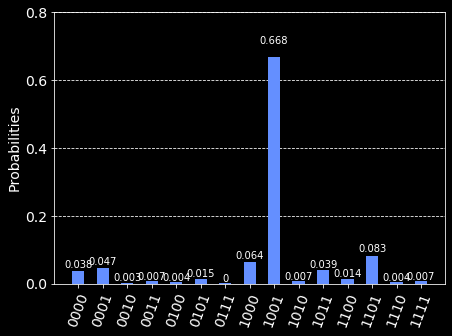

In [37]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [38]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)

In [39]:
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

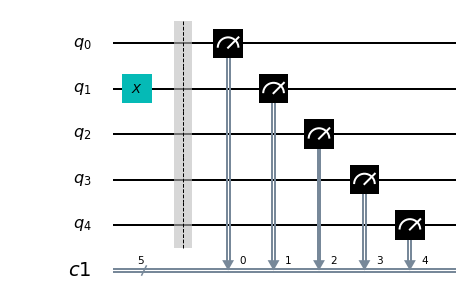

In [40]:
cal_circuits[2].draw(output = 'mpl')

In [57]:
cal_job = execute(cal_circuits,
                 backend = device,
                 shots = 500,
                 optimization_level = 0
                 )
print(cal_job.job_id())
job_monitor(cal_job)
cal_results= cal_job.result()

5ebef9dd927380001bb7fdda
Job Status: job has successfully run


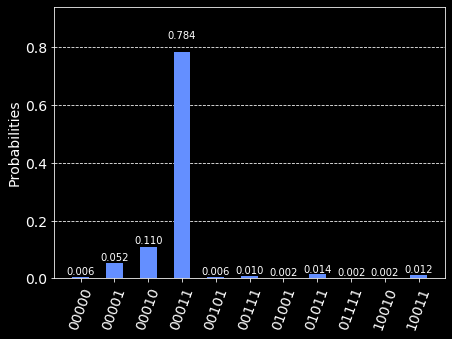

In [64]:
plot_histogram(
    cal_results.get_counts(cal_circuits[3])
)

Less errors

In [59]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

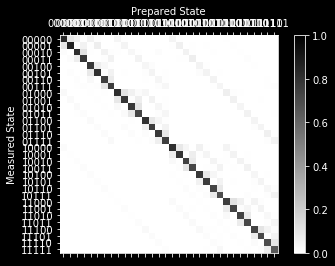

In [60]:
meas_fitter.plot_calibration()

In [61]:
meas_filter = meas_fitter.filter

In [62]:
mitigated_result = meas_filter.apply(device_result)

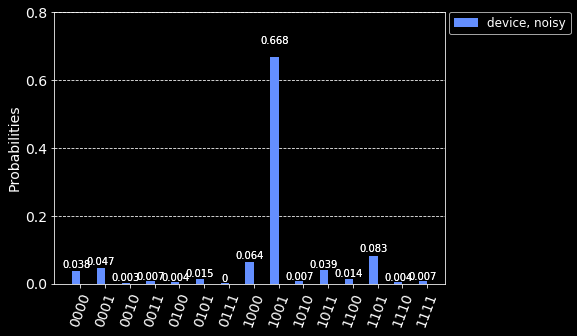

In [63]:
device_counts = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device, noisy', 'device, mitigated'])

Unfortunately, in the above histogram we can see the initial results when first running our programme to a device and not the results depicted in the previous histogram (which are the mitigated resutls). 

Another Example

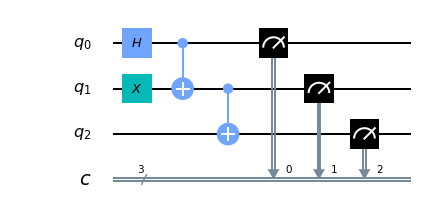

In [43]:
#circuit2 = QuantumCircuit(3,3)
#circuit2.x(1)
#circuit2.h(0)
#circuit2.cx(0,1)
#circuit2.cx(1,2)
#circuit2.measure([0,1,2], [0,1,2])
#circuit2.draw(output='mpl')

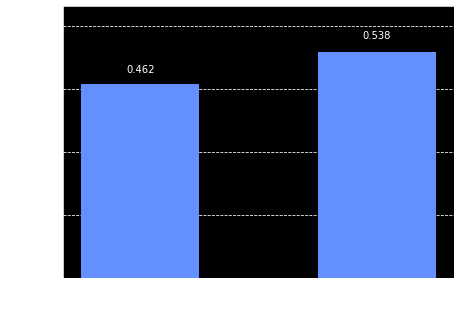

In [44]:
#plot_histogram(
    #execute(circuit2, backend=simulator, shots = 1024).result().get_counts(circuit2)
#)

In [45]:
#device_counts_2 = execute(circuit2, backend= device, shots=1024).result().get_counts(circuit2)

In [65]:
device_counts = execute(circuit, backend= device, shots=1024).result().get_counts(circuit)

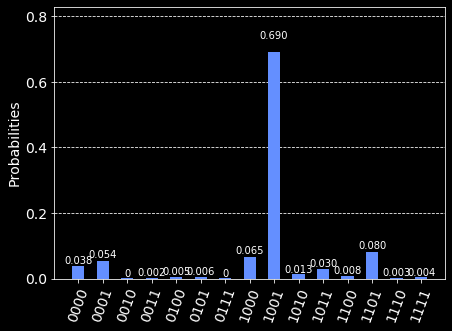

In [66]:
plot_histogram(device_counts)

In [47]:
#device_mitigated_counts_2 = meas_filter.apply(device_counts_2)

In [70]:
device_mitigated_counts = meas_filter.apply(device_counts)

In [73]:
plot_histogram(device_mitigated_counts_2)

NameError: name 'device_mitigated_counts_2' is not defined

So in these two examples we saw how noise in quantum computers can bring us results different than the ones on the QASM Simulator (e.g. the ideal QC). With the Ignis package from Qiskit we were able to understand what those errors where, identify those faulty parameters and pass them through a fitter, and then though the fitter we generated a filter that helped us mitigate those errors.